<a href="https://colab.research.google.com/github/aksarburak/AIX360/blob/master/explainability/Autoencoder_Explainability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install numpy==1.15.0

In [0]:
%tensorflow_version 2.x

In [4]:
!nvidia-smi

Fri Apr 17 02:21:18 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    32W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [5]:
import copy
import datetime
import logging
import io
import random
import os
import sys
from functools import partial

import pandas as pd
import numpy as np
from pylab import rcParams
from scipy.io import loadmat
from scipy.interpolate import interp1d


import tensorflow as tf
import logging


from tensorflow.keras.models import Sequential, Model

#from keras.models import Model, Sequential
from keras.utils import plot_model
from keras import backend as K
import tensorflow.keras.layers as layers
#from tensorflow import keras


from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dense, Conv1D, Dropout, Flatten, MaxPooling1D, Conv2D, MaxPooling2D, Activation
from tensorflow.keras.layers import LSTM, RepeatVector, TimeDistributed, Flatten, Input
from tensorflow.keras.regularizers import l1,l2,l1_l2
from tensorflow.keras.models import Model, load_model


from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping, ReduceLROnPlateau

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns
import random

import h5py
import pickle

from numpy.random import seed
seed(7)

rcParams['figure.figsize'] = 8, 6
#SEED = 123 #used to help randomly select the data points

import time
print(tf.version.VERSION)
print(tf.test.gpu_device_name())

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


2.2.0-rc3
/device:GPU:0


In [0]:
tf.config.list_physical_devices('GPU')
tf.random.set_seed(0)

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
class MyEncoder:
    def fit_transform(self, labels):
        self.fit(labels)
        return self.transform(labels)

    def fit(self, labels):
        self.labels = labels['label'].unique()
        self.label_dict = {}
        for idx, i in enumerate(self.labels):
            self.label_dict[i] = idx
            
    def transform(self, labels):
        return labels['label'].apply(self.label_dict.get)

In [0]:
logging.basicConfig(format='%(asctime)s %(levelname)-7s %(message)s',
                    stream=sys.stderr, level=logging.DEBUG)
mpl_logger = logging.getLogger('matplotlib')
mpl_logger.setLevel(logging.WARNING) 

In [10]:
raw_labels = pd.read_hdf('/content/drive/My Drive/PhD/Colab Notebooks/Explainability_Colab/explainability_data/train_labels.hdf')
#Deleted network anomaly
raw_labels = raw_labels[raw_labels.label != 'network']

label_count = len(raw_labels['label'].unique()) 


encoder = MyEncoder()
train_labels = pd.DataFrame(encoder.fit_transform(raw_labels).to_numpy(),
                      index=raw_labels.index.get_level_values('node_id'))

raw_labels = pd.read_hdf('/content/drive/My Drive/PhD/Colab Notebooks/Explainability_Colab/explainability_data/test_labels.hdf')

#Deleted network anomaly
raw_labels = raw_labels[raw_labels.label != 'network']

test_labels = pd.DataFrame(encoder.transform(raw_labels).to_numpy(),
                      index=raw_labels.index.get_level_values('node_id'))
logging.info("Loaded labels")

2020-04-17 02:22:25,062 INFO    NumExpr defaulting to 4 threads.
2020-04-17 02:22:25,567 INFO    Loaded labels


In [11]:
train_data = pd.read_hdf('/content/drive/My Drive/PhD/Colab Notebooks/Explainability_Colab/explainability_data/train.hdf')
train_data = train_data[[x for x in train_data.columns if 'papi' not in x and 'per_core' not in x and 'PAPI' not in x]]
#train_data = train_data[[x for x in train_data.columns if 'per_core' not in x ]]
print(train_data.shape)
metric_count = len(train_data.columns)

# NOTE: I am not loading test data because data is already too big
test_data = pd.read_hdf('/content/drive/My Drive/PhD/Colab Notebooks/Explainability_Colab/explainability_data/test.hdf')
test_data = test_data[train_data.columns]
print(test_data.shape)


(214068, 199)
(135850, 199)


In [0]:
nodeid_df = pd.read_csv('/content/drive/My Drive/PhD/Colab Notebooks/Explainability_Colab/explainability_data/nids.csv')

In [0]:
train_data_full = pd.concat([train_data, test_data])
train_labels_full = pd.concat([train_labels, test_labels])

In [14]:
#### FIXME: why unique label count is different for label and data index?????? - FIXED: Because I deleted network anom
print(len(train_data_full.index.get_level_values('node_id').unique()))
print(len(train_labels_full.index.unique()))
print("Label distribution \n \n",train_labels_full[0].value_counts())

809
617
Label distribution 
 
 4    377
2     51
1     49
3     48
0     48
5     44
Name: 0, dtype: int64


In [0]:
#We need to check first intersection between nodeid_df and train_labels_full
#Because we dropped network anomalies and there is a mismatch
unique_nids = train_labels_full.index.array
nodeid_df = nodeid_df[nodeid_df.node_id.isin(unique_nids)]

In [0]:
#Add labels to nodeid dataframe with actual node ids
label_list = []
node_ids = nodeid_df['node_id']
for node_id in node_ids:
    label_list.append(train_labels_full.loc[node_id].array[0])

nodeid_df['label']=label_list 

In [97]:
actual_ids = nodeid_df['nid'].unique()
print(actual_ids)
nodeid_df[nodeid_df['nid'] == 57]
#TODO: I manually choose the node that has healthy and cpuoccupy runs, if you want automate later

[30 31 60 61 56 57 58 59 52 53 54 55 26 27 28 29 23 24 25 22 20 21]


,nid,node_id,label
5,57,5c1316a71963fd7bbf0f90b6,0
61,57,5c1318e01963fd7bbf0f925a,4
91,57,5c13197a1963fd7bbf0f92cf,4
97,57,5c1319a11963fd7bbf0f92eb,2
101,57,5c1319a71963fd7bbf0f92f0,2
117,57,5c131a511963fd7bbf0f9372,4
140,57,5c15412339747d4a8fa8f6fc,4
183,57,5c15422f39747d4a8fa8f80a,4
189,57,5c15426b39747d4a8fa8f844,3
273,57,5c15440c39747d4a8fa8f9e8,2


In [0]:
def choose_node_data(node_id,label):
    #Manually choose the node [number]
    #Make the training data ready
    node_list = nodeid_df[(nodeid_df.nid == node_id) & (nodeid_df.label == label)].node_id
    print(len(node_list))
    node_df = train_data_full[train_data_full.index.get_level_values('node_id').isin(node_list)]
    assert len(node_df.index.get_level_values('node_id').unique()) == len(node_list)    

    #Make the training label ready
    node_df_label = train_labels_full.loc[node_list]
    assert len(node_list) == len(node_df_label)

    return node_df,node_df_label

In [111]:
encoder.label_dict

{'dcopy': 5,
 'dial': 0,
 'leak': 1,
 'memeater': 2,
 'memorybandwidth': 3,
 'none': 4}

In [146]:
node_train, node_train_label = choose_node_data(57,4)
node_train, node_test_healthy = train_test_split(node_train,test_size=0.2,random_state=0)
### 
node_test_anom, node_test_anom_label = choose_node_data(57,0)

18
5


In [222]:
#DropNANs before scale and train!

#TRAIN SET - Healthy
node_train = node_train.dropna()
print("Is NaN",np.any(np.isnan(node_train)))

scaler = MinMaxScaler(feature_range=(0, 1))
node_train = pd.DataFrame(scaler.fit_transform(node_train), columns=node_train.columns, index=node_train.index)

#TEST SET - Healthy
node_test_healthy = node_test_healthy.dropna()
print("Is NaN",np.any(np.isnan(node_test_healthy)))

scaler = MinMaxScaler(feature_range=(0, 1))
node_test_healthy = pd.DataFrame(scaler.fit_transform(node_test_healthy), columns=node_test_healthy.columns, index=node_test_healthy.index)


#TEST SET - ANOM
node_test_anom = node_test_anom.dropna()
print("Is NaN",np.any(np.isnan(node_test_anom)))

node_test_anom = pd.DataFrame(scaler.fit_transform(node_test_anom), columns=node_test_anom.columns, index=node_test_anom.index)


Is NaN False
Is NaN False
Is NaN False


In [0]:
class WindowShopper: 

    def __init__(self, data, labels, window_size = 64, label_count = 2, trim=30):
        self.data = data
        self.labels = labels
        self.window_size = window_size
        self.label_count = label_count
        self.trim = trim
        #new full dataset 
        self.windowed_data = []
        self.windowed_label = []
        self.metric_count = len(data.columns)
        #self._process_sample_count()
        self.output_shape = (self.window_size, self.metric_count)    
        self._get_windowed_dataset()
    
    def _process_sample_count(self):
        self.per_label_count = {x: 0 for x in self.labels[self.labels.columns[0]].unique()}
        self.sample_count = 0
        for node_id in self.data.index.get_level_values('node_id').unique():
            counter = 0
            cur_array = self.data.loc[node_id, :, :]
            for i in range(self.trim, len(cur_array) - self.window_size - self.trim):
                counter += 1
            self.sample_count += counter
            self.per_label_count[self.labels.loc[node_id, self.labels.columns[0]]] += counter

    def _get_windowed_dataset(self):

        # for node_id in self.data.index.get_level_values('node_id').unique():
        for node_id in self.labels.index.unique():
          # print(node_id)
          cur_array = self.data.loc[node_id,:,:]
          
          temp_data = []
          temp_label = []
          for i in range(self.trim, len(cur_array) - self.window_size - self.trim):                 

              self.windowed_data.append(cur_array.iloc[i:i+self.window_size].to_numpy(
                  dtype=np.float32).reshape(self.output_shape))
              self.windowed_label.append(self.labels.loc[node_id])


        self.windowed_data = np.dstack(self.windowed_data)
        self.windowed_data = np.rollaxis(self.windowed_data,2)
        self.windowed_label = np.asarray(self.windowed_label).reshape(len(self.windowed_label),1)       

In [0]:
## Windowed approach
# window_size = 45

# #REPLACE NODE IDS 
# getter = WindowShopper(train_data_full, train_labels_full, window_size=window_size, label_count=label_count)

# x_train = getter.windowed_data
# y_train = getter.windowed_label

# print(x_train.shape)
# print(y_train.shape)


In [149]:
n_features = node_train.shape[1]
n_features

199

In [150]:
node_train.shape

(5780, 199)

In [151]:
node_test.shape

(2703, 199)

In [0]:
encoding_dim = n_features*10

input_data = Input(shape=(n_features))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu',activity_regularizer=l1())(input_data)
drop1 = Dropout(0.2)(encoded)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(n_features, activation='linear')(drop1)
drop2 = Dropout(0.2)(decoded)

# this model maps an input to its reconstruction
model = Model(input_data, drop2)

In [153]:
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 199)]             0         
_________________________________________________________________
dense_4 (Dense)              (None, 1990)              398000    
_________________________________________________________________
dropout_4 (Dropout)          (None, 1990)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 199)               396209    
_________________________________________________________________
dropout_5 (Dropout)          (None, 199)               0         
Total params: 794,209
Trainable params: 794,209
Non-trainable params: 0
_________________________________________________________________


In [0]:
#If you wanna save the model
output_directory = "/content/drive/My Drive/PhD/Colab Notebooks/Explainability_Colab/Checkpoints/"
folder_name = 'exp_autoencoder' #folder to be generated

if not os.path.isdir(output_directory + folder_name):
    os.mkdir(output_directory + folder_name)

In [0]:
# %load_ext tensorboard
# logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
# %tensorboard --logdir logs

In [155]:
epochs = 100
batch = 32
lr = 0.001

### Make an optimizer choice ###

adam = optimizers.Adam(lr,beta_1=0.9,beta_2=0.999)

### Compile ###
model.compile(loss='mae', optimizer=adam, metrics=['mae'])


### Callbacks ###
cp = ModelCheckpoint(filepath=output_directory+folder_name+"/checkpoint_classifier.h5",
                               save_best_only=True,monitor='val_loss', mode ='min',
                               verbose=0)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)

# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, 
#       min_lr=0.00001,verbose=1)

#tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir, histogram_freq=1)

### Fit the model ###
model_history = model.fit(node_train, node_train, 
                                                epochs=epochs, 
                                                batch_size=batch,
                                                callbacks=[
                                                           cp,
                                                            es,
                                                        #    reduce_lr,
                                                        #   tensorboard_callback
                                                           ],
                                                validation_split=0.1, 
                                                shuffle=True,                                                
                                                verbose=2).history

model.save(output_directory+folder_name+"/model.hdf5")
model.save_weights(output_directory+folder_name+"/model_weights.hdf5")

Epoch 1/100
163/163 - 1s - loss: 0.1676 - mae: 0.1441 - val_loss: 0.1284 - val_mae: 0.1293
Epoch 2/100
163/163 - 1s - loss: 0.1168 - mae: 0.1169 - val_loss: 0.1065 - val_mae: 0.1066
Epoch 3/100
163/163 - 1s - loss: 0.0987 - mae: 0.0987 - val_loss: 0.0899 - val_mae: 0.0891
Epoch 4/100
163/163 - 1s - loss: 0.0855 - mae: 0.0856 - val_loss: 0.0802 - val_mae: 0.0790
Epoch 5/100
163/163 - 1s - loss: 0.0815 - mae: 0.0814 - val_loss: 0.0766 - val_mae: 0.0753
Epoch 6/100
163/163 - 1s - loss: 0.0800 - mae: 0.0800 - val_loss: 0.0752 - val_mae: 0.0738
Epoch 7/100
163/163 - 1s - loss: 0.0791 - mae: 0.0791 - val_loss: 0.0744 - val_mae: 0.0729
Epoch 8/100
163/163 - 1s - loss: 0.0790 - mae: 0.0789 - val_loss: 0.0741 - val_mae: 0.0726
Epoch 9/100
163/163 - 1s - loss: 0.0788 - mae: 0.0788 - val_loss: 0.0741 - val_mae: 0.0726
Epoch 10/100
163/163 - 1s - loss: 0.0788 - mae: 0.0788 - val_loss: 0.0741 - val_mae: 0.0727
Epoch 11/100
163/163 - 1s - loss: 0.0784 - mae: 0.0784 - val_loss: 0.0742 - val_mae: 0.07

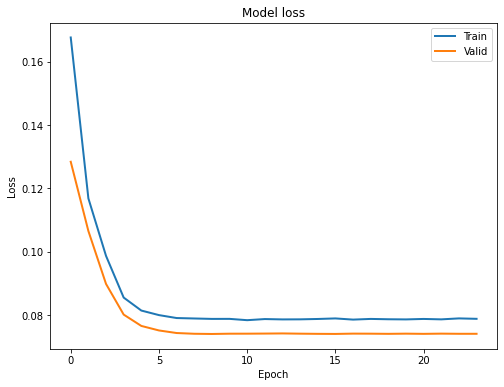

In [156]:
plt.plot(model_history['loss'], linewidth=2, label='Train')
plt.plot(model_history['val_loss'], linewidth=2, label='Valid')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.savefig(output_directory + folder_name + "/loss")
plt.show()

In [0]:
# # # # #If you wanna load from the directory, otherwise skip
# output_directory = "/content/drive/My Drive/PhD/Colab Notebooks/Explainability_Colab/Checkpoints/"
# save_name = 'result_model13_50epochs'
# loaded_model = load_model(output_directory+save_name+"/model.hdf5")
# loaded_model.summary()
# model = loaded_model

In [0]:
# TODO:

# Distactor true label'dan gelmeli - Emre
# Thresholdu sec, training datasindan
# Test cpu occupy 
# Sonra cpu occupy'dan ne kadar uzaklastik ona karar ver


###Prediction

In [0]:
recon_healthy = model.predict(node_test_healthy)
diff_healthy = np.abs(np.array(node_test_healthy) - recon_healthy)
max_error_healthy = pd.DataFrame(np.array(np.max(diff_healthy,axis=1)))

In [0]:
recon_anom = model.predict(node_test_anom)
diff_anom = np.abs(np.array(node_test_anom) - recon_anom)
max_error_anom = pd.DataFrame(np.array(np.max(diff_anom,axis=1)))

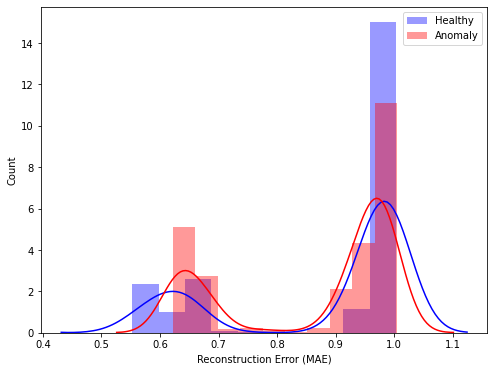

In [228]:
# plt.axvline(x=thres_90, color='k',linewidth=4, ls='--')
# plt.axvline(x=thres_95, color='y', linewidth=4, ls='--')

sns.distplot(max_error_healthy,bins=10,color='b')
sns.distplot(max_error_anom,bins=10,color='r')
plt.legend(labels=["Healthy","Anomaly"])
plt.xlabel("Reconstruction Error (MAE)")
plt.ylabel("Count")

#plt.title("MAE Distribution - Healthy vs. " + anom_name)
#plt.savefig(output_directory + folder_name + "/Healthy-" +anom_name+"-MAE")

plt.show()

### Functions

In [0]:
#Calculates MAE for each window
def MAE(X,X_predict):
    mae_list = []
    mae_list_rescale = [] 
    len_data = X.shape[0]
    for i in range(len_data):
      t_X = X[i,:,:]
      t_X_predict = X_predict[i,:,:] 
      mae_window = np.mean(np.abs(t_X_predict - t_X), axis=1).mean()
      mae_list.append(mae_window)
      # mae_list.append(mean_squared_error(t_X,t_X_predict))
      #mse_list_rescale.append(mean_squared_error(scaler.inverse_transform(t_X),scaler.inverse_transform(t_X_predict)))
    mae_df = pd.DataFrame(mae_list)

    return mae_df

In [0]:
#Calculates MSE for each window
def MSE(X,X_predict):
    mse_list = []
    mse_list_rescale = [] 
    len_data = X.shape[0]
    for i in range(len_data):
      t_X = X[i,:,:]
      t_X_predict = X_predict[i,:,:] 
      mse_list.append(mean_squared_error(t_X,t_X_predict))
      #mse_list_rescale.append(mean_squared_error(scaler.inverse_transform(t_X),scaler.inverse_transform(t_X_predict)))

    mse_df = pd.DataFrame(mse_list)
    return mse_df

In [0]:
def analyze(X,X_pred):
  #mse_train = np.mean(np.power(flatten(X) - flatten(X_pred), 2), axis=1)
  #print("Flatten approach",np.mean(mse_train))  
  mse_list, mse_list_rescaled = MSE(X,X_pred)
  
  mse_list = np.array(mse_list)
  temp_df = pd.DataFrame(mse_list)
  print(temp_df.describe(percentiles = [.25,.5,.75,.9,.95]))
  
  # mse_list_rescaled = np.array(mse_list_rescaled)
  # temp_df = pd.DataFrame(mse_list_rescaled)
  # print(temp_df.describe(percentiles = [.25,.5,.75,.9,.95]))

  return mse_list, mse_list_rescaled

In [0]:
def test(X_test):
  
  predicted_test = model.predict(X_test)
  mae_df_test = MAE(X_test,predicted_test)
  return mae_df_test


In [0]:
def test_MSE(X_test):
  
  predicted_test = model.predict(X_test)
  mse_df_test = MSE(X_test,predicted_test)

  return mse_df_test

In [0]:
def analyze_feature_errors(X,X_predict):
    #X is original
    #X is prediction
    mae_df = pd.DataFrame()
    mae_sample_list = []
    num_feature = X.shape[2]

    for sample in range(X.shape[0]):

        t_X = X[sample,:]
        t_X_predict = X_predict[sample,:] 

        sample_feature_diff = np.abs(t_X_predict - t_X)
        #print(sample_feature_diff.shape)
        sample_feature_mean = np.mean(sample_feature_diff,axis=0).reshape(1,num_feature)
        #print(sample_feature_mean.shape)
        assert sample_feature_mean.shape == (1,num_feature)
        
        temp_df = pd.DataFrame(sample_feature_mean)
        mae_df = pd.concat([mae_df,temp_df],axis=0,ignore_index=True)

    return mae_df

In [0]:
def plot_overall_analysis(train,train_predict,anom,anom_predict,anom_name):

    #Comparison with healthy reconstruction vs. anomaly
    mae_df_healthy = MAE(train,train_predict)
    mae_df_anom = MAE(anom,anom_predict)

    healthy_stats = mae_df_healthy.describe(percentiles=[.25,.5,.75,.9,.95])
    #anom_stats = mae_df_anom.describe(percentiles=[.25,.5,.75,.9,.95])
    thres_90 = healthy_stats.iloc[7][0]
    thres_95 = healthy_stats.iloc[8][0]
    #print("Training data stats",train_data_stats)
    #print("Anom data stats",anom_stats)

    plt.axvline(x=thres_90, color='k',linewidth=4, ls='--')
    plt.axvline(x=thres_95, color='y', linewidth=4, ls='--')
    sns.distplot(mae_df_healthy,bins=200,kde=True,color='b')
    sns.distplot(mae_df_anom,bins=200,kde=True,color='r')
    plt.legend(labels=["90th Percentile ","95th Percentile","Healthy",anom_name])
    plt.xlabel("Reconstruction Error (MAE)")
    plt.ylabel("Count")

    plt.title("MAE Distribution - Healthy vs. " + anom_name)
    plt.savefig(output_directory + folder_name + "/Healthy-" +anom_name+"-MAE")
    plt.show()


In [0]:
def plot_feature_analysis(train,train_predict,anom,anom_predict,anom_name):

    mae_features_healthy = analyze_feature_errors(train,train_predict)
    mae_features_anom = analyze_feature_errors(anom,anom_predict)
    
    #hold feature counts that exceeds threshold 
    count_dict = {}
    
    assert mae_features_healthy.shape[0] == mae_features_anom.shape[0]

    #Feature is actually an index
    for feature in range(mae_features_healthy.shape[1]):
    #for feature in range(0,10,1):

        a = mae_features_anom[feature]
        h = mae_features_healthy[feature]

        healthy_stats = mae_features_healthy[feature].describe(percentiles=[.25,.5,.75,.9,.95])
        anom_stats = mae_features_anom[feature].describe(percentiles=[.25,.5,.75,.9,.95])
        
        #Feature by feature threshold
        thres_90 = healthy_stats.iloc[7]
        thres_95 = healthy_stats.iloc[8]

        acc_rate_90 = ((np.sum(a > thres_90) / a.shape[0]) * 100)
        acc_rate_95 = ((np.sum(a > thres_95) / a.shape[0]) * 100)
        acc_rate_90 = round(acc_rate_90,2)
        acc_rate_95 = round(acc_rate_95,2)
        # print("Acc_rate 90: ",acc_rate_90)
        # print("Acc_rate 95: ",acc_rate_95)

        if(acc_rate_90>70):

            if "70" in count_dict:
                count_dict["70"].append(train_data_full.columns[feature]) 
            else:
                count_dict["70"] = [train_data_full.columns[feature]]

        if (acc_rate_90 > 85):

            if "85" in count_dict:
                count_dict["85"].append(train_data_full.columns[feature]) 
            else:
                count_dict["85"] = [train_data_full.columns[feature]]

            print("Anom data stats",anom_stats)
            x_limiter = anom_stats.iloc[7] * 2

            sns.distplot(h,kde=True,color='b')
            sns.distplot(a,kde=True,color='r')    
            
            plt.axvline(x=thres_90, color='k',linewidth=4, ls='--')
            plt.axvline(x=thres_95, color='y', linewidth=4, ls='--')
            ax = plt.axes()
            plt.text(0.5,0.95, transform=ax.transAxes, s='90%_Acc: ' + str(acc_rate_90), style='italic',
            bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 5})
            plt.text(0.5,0.85, transform=ax.transAxes, s='95%_Acc: ' + str(acc_rate_95), style='italic',
            bbox={'facecolor': 'blue', 'alpha': 0.5, 'pad': 5})

            plt.legend(labels=["90th Percentile ","95th Percentile","Healthy",anom_name])

            plt.title(train_data_full.columns[feature] + " Error Distribution over Dataset")
            plt.xlabel("Reconstruction Error (MAE)")
            plt.xlim(0,x_limiter)
            plt.ylabel("Count")
            #plt.annotate(acc_rate_90,xy=(0.8,0.8))
            #plt.savefig(output_directory + folder_name + "/" + anom_name +"_" + train_data_full.columns[feature])
            plt.show()
    
    return count_dict


In [0]:
#Generates random sub_train and sub_train_predict datasets
def select_random_samples(train,train_predict,sample_size):
    
    rand_indices = random.sample(range(0, train.shape[0]), sample_size)

    sub_train = []
    sub_train_predict = []

    for ind in rand_indices:
        sub_train.append(train[ind,:])
        sub_train_predict.append(train_predict[ind,:])

    sub_train = np.dstack(sub_train)
    sub_train = np.rollaxis(sub_train,2)

    sub_train_predict = np.dstack(sub_train_predict)
    sub_train_predict = np.rollaxis(sub_train_predict,2)

    return sub_train,sub_train_predict

###Subsampling Dataset 

In [0]:
getter = WindowShopper(train_data_full, y_test_1, window_size=window_size, label_count=label_count)
train_data_y1 = getter.windowed_data
train_label_y1 = getter.windowed_label
print(train_data_y1.shape)
print(train_label_y1.shape)

(19420, 45, 199)
(19420, 1)


In [0]:
#modification for smaller dataset
train_data_y5 = train_healthy

In [0]:
encoder.label_dict

{'dcopy': 6,
 'dial': 1,
 'leak': 2,
 'memeater': 3,
 'memorybandwidth': 4,
 'network': 0,
 'none': 5}

In [0]:
##Get the outputs and prepare for analysis

#Train data prediction 
predicted_train = model.predict(train_data_y5)
#predicted_test = model.predict(test_data_y5)

#Will choose random samples from training data according to number of examples in the anomalous examples
sub_train_y1, sub_train_predict_y1 = select_random_samples(train_data_y5,predicted_train,train_data_y1.shape[0])
print(sub_train_y1.shape)
print(sub_train_predict_y1.shape)

sub_train_y2, sub_train_predict_y2 = select_random_samples(train_data_y5,predicted_train,train_data_y2.shape[0])
print(sub_train_y2.shape)
print(sub_train_predict_y2.shape)

sub_train_y3, sub_train_predict_y3 = select_random_samples(train_data_y5,predicted_train,train_data_y3.shape[0])
print(sub_train_y3.shape)
print(sub_train_predict_y3.shape)

sub_train_y4, sub_train_predict_y4 = select_random_samples(train_data_y5,predicted_train,train_data_y4.shape[0])
print(sub_train_y4.shape)
print(sub_train_predict_y4.shape)

sub_train_y6, sub_train_predict_y6 = select_random_samples(train_data_y5,predicted_train,train_data_y6.shape[0])
print(sub_train_y6.shape)
print(sub_train_predict_y6.shape)

#Prediction for anomalous examples
predicted_cpuoccupy = model.predict(train_data_y1) #sub_train_y1
predicted_memleak = model.predict(train_data_y2) #sub_train_y2
predicted_memeater = model.predict(train_data_y3) #sub_train_y3
predicted_membw = model.predict(train_data_y4) #sub_train_y4
predicted_cachecopy = model.predict(train_data_y4) #sub_train_y4

(19420, 45, 199)
(19420, 45, 199)
(14628, 45, 199)
(14628, 45, 199)
(15511, 45, 199)
(15511, 45, 199)
(19639, 45, 199)
(19639, 45, 199)
(17887, 45, 199)
(17887, 45, 199)


###Feature and MAE Graphs Analysis

In [0]:
##Get the outputs and prepare for analysis

#Train data prediction 
#predicted_train = model.predict(train_data_y5)
#predicted_test = model.predict(test_data_y5)

#Will choose random samples from training data according to number of examples in the anomalous examples
sub_train_y1, sub_train_predict_y1 = select_random_samples(train_data_y5,predicted_train,train_data_y1.shape[0])
print(sub_train_y1.shape)
print(sub_train_predict_y1.shape)

sub_train_y2, sub_train_predict_y2 = select_random_samples(train_data_y5,predicted_train,train_data_y2.shape[0])
print(sub_train_y2.shape)
print(sub_train_predict_y2.shape)

sub_train_y3, sub_train_predict_y3 = select_random_samples(train_data_y5,predicted_train,train_data_y3.shape[0])
print(sub_train_y3.shape)
print(sub_train_predict_y3.shape)

sub_train_y4, sub_train_predict_y4 = select_random_samples(train_data_y5,predicted_train,train_data_y4.shape[0])
print(sub_train_y4.shape)
print(sub_train_predict_y4.shape)

sub_train_y6, sub_train_predict_y6 = select_random_samples(train_data_y5,predicted_train,train_data_y6.shape[0])
print(sub_train_y6.shape)
print(sub_train_predict_y6.shape)


#Prediction for anomalous examples
# predicted_dial = model.predict(train_data_y1) #sub_train_y1
# predicted_memleak = model.predict(train_data_y2) #sub_train_y2
# predicted_memeater = model.predict(train_data_y3) #sub_train_y3
# predicted_membw = model.predict(train_data_y4) #sub_train_y4

(19420, 45, 199)
(19420, 45, 199)
(14628, 45, 199)
(14628, 45, 199)
(15511, 45, 199)
(15511, 45, 199)
(19639, 45, 199)
(19639, 45, 199)
(17887, 45, 199)
(17887, 45, 199)


In [0]:
########Graphs#######

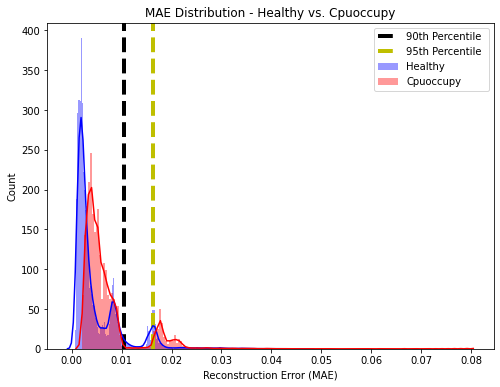

In [0]:
plot_overall_analysis(sub_train_y1,sub_train_predict_y1,train_data_y1,predicted_cpuoccupy,"Cpuoccupy")

Anom data stats count    19420.000000
mean         0.040458
std          0.020986
min          0.026309
25%          0.031535
50%          0.034272
75%          0.038538
90%          0.044917
95%          0.111713
max          0.216095
Name: 9, dtype: float64


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:54: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


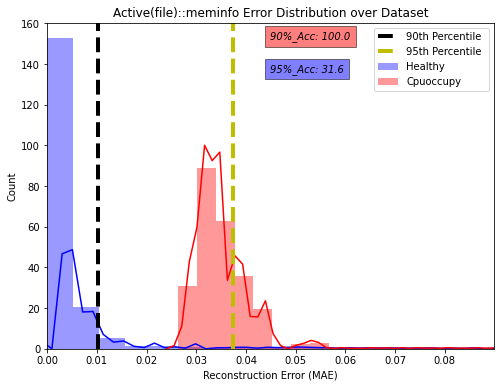

Anom data stats count    19420.000000
mean         0.040351
std          0.021001
min          0.026024
25%          0.031614
50%          0.033932
75%          0.038478
90%          0.045320
95%          0.111608
max          0.216934
Name: 42, dtype: float64


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:54: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


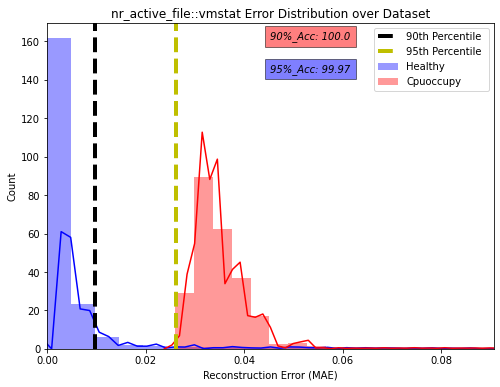

Anom data stats count    19420.000000
mean         0.014378
std          0.016247
min          0.006907
25%          0.011093
50%          0.012179
75%          0.013184
90%          0.014384
95%          0.015776
max          0.351609
Name: 157, dtype: float64


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:54: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


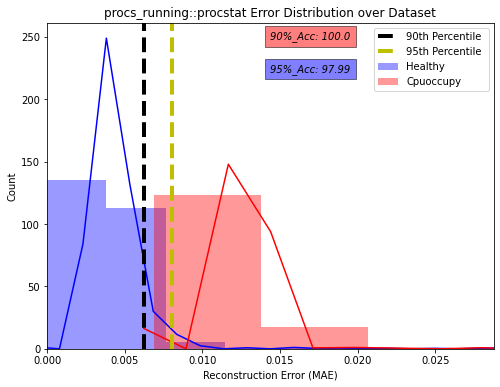

Anom data stats count    19420.000000
mean         0.012985
std          0.016388
min          0.007420
25%          0.009598
50%          0.010295
75%          0.011435
90%          0.012903
95%          0.014663
max          0.353235
Name: 168, dtype: float64


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:54: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


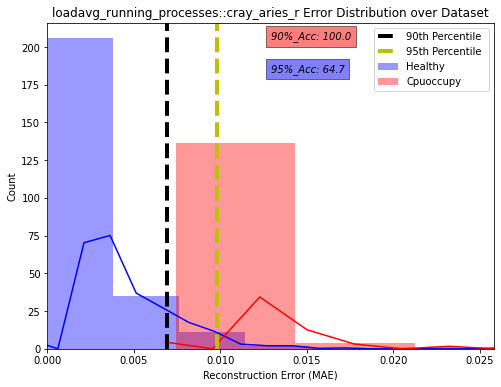

In [0]:
count_dict_y1 = plot_feature_analysis(sub_train_y1,sub_train_predict_y1,train_data_y1,predicted_cpuoccupy,"Cpuoccupy")

In [0]:
count_dict_y1

{'70': ['Active::meminfo',
  'Active(file)::meminfo',
  'nr_active_file::vmstat',
  'procs_running::procstat',
  'loadavg_running_processes::cray_aries_r'],
 '85': ['Active(file)::meminfo',
  'nr_active_file::vmstat',
  'procs_running::procstat',
  'loadavg_running_processes::cray_aries_r']}

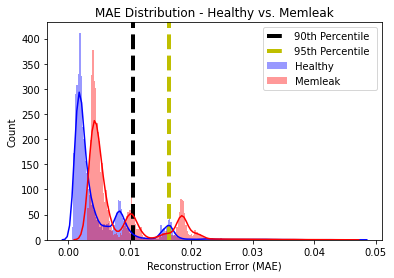

In [0]:
plot_overall_analysis(sub_train_y2,sub_train_predict_y2,train_data_y2,predicted_memleak,"Memleak")

Anom data stats count    14628.000000
mean         0.021840
std          0.016968
min          0.000994
25%          0.013016
50%          0.020321
75%          0.027482
90%          0.032989
95%          0.037113
max          0.292121
Name: 0, dtype: float64


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:54: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


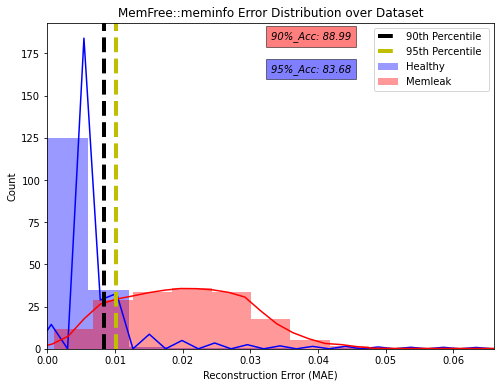

Anom data stats count    14628.000000
mean         0.021847
std          0.016974
min          0.001044
25%          0.013012
50%          0.020332
75%          0.027497
90%          0.032988
95%          0.037138
max          0.292119
Name: 1, dtype: float64


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:54: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


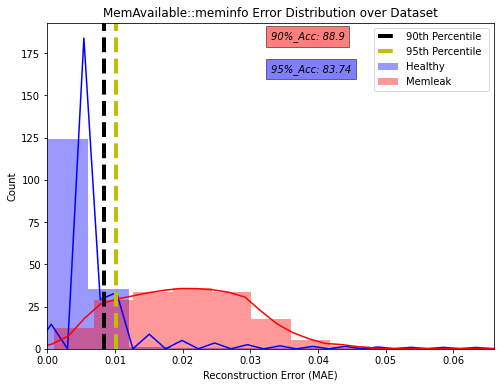

Anom data stats count    14628.000000
mean         0.043335
std          0.027289
min          0.002593
25%          0.031262
50%          0.034027
75%          0.038520
90%          0.107279
95%          0.118946
max          0.221186
Name: 9, dtype: float64


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:54: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


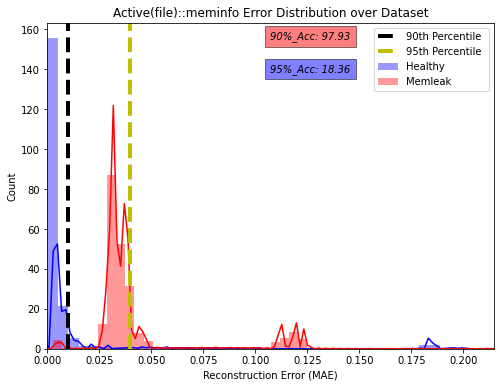

Anom data stats count    14628.000000
mean         0.023378
std          0.016527
min          0.001050
25%          0.014858
50%          0.021933
75%          0.028984
90%          0.033370
95%          0.035883
max          0.299130
Name: 28, dtype: float64


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:54: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


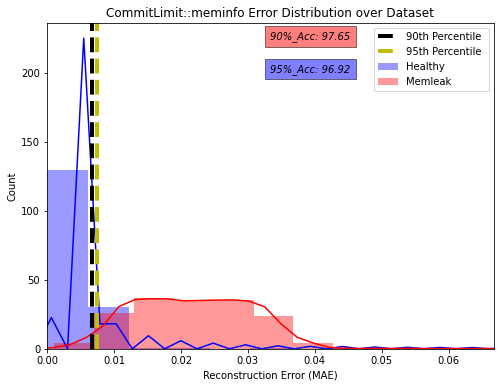

Anom data stats count    14628.000000
mean         0.021887
std          0.017079
min          0.003110
25%          0.013001
50%          0.020475
75%          0.027729
90%          0.032166
95%          0.034974
max          0.304582
Name: 33, dtype: float64


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:54: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


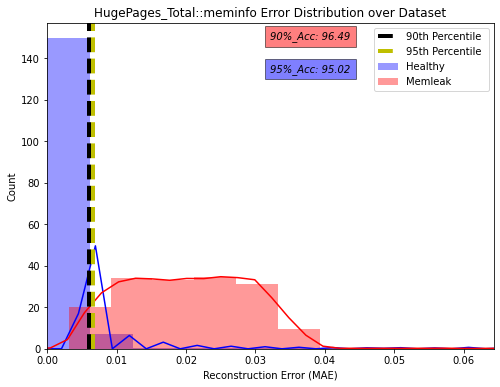

Anom data stats count    14628.000000
mean         0.021961
std          0.017068
min          0.002207
25%          0.013051
50%          0.020515
75%          0.027737
90%          0.032402
95%          0.035141
max          0.304695
Name: 36, dtype: float64


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:54: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


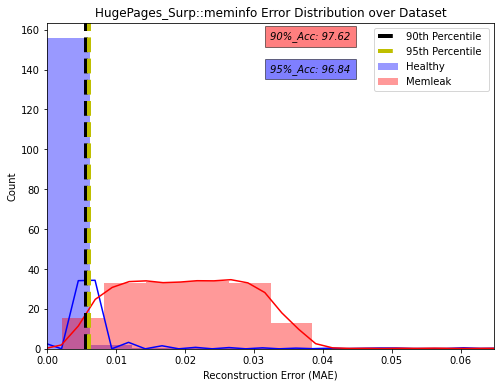

Anom data stats count    14628.000000
mean         0.021866
std          0.016967
min          0.001046
25%          0.013043
50%          0.020346
75%          0.027511
90%          0.033004
95%          0.037182
max          0.292062
Name: 37, dtype: float64


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:54: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


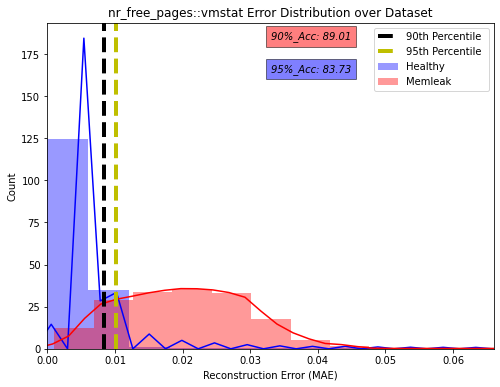

Anom data stats count    14628.000000
mean         0.043163
std          0.026900
min          0.002247
25%          0.031049
50%          0.034097
75%          0.038635
90%          0.098754
95%          0.119468
max          0.222331
Name: 42, dtype: float64


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:54: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


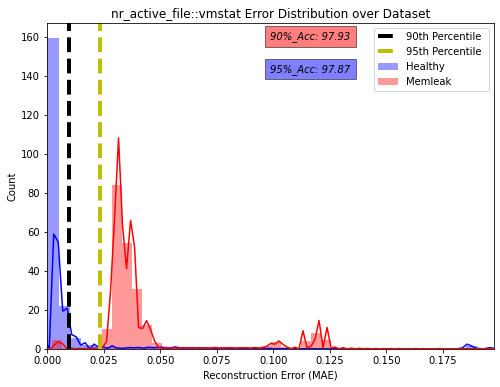

Anom data stats count    14628.000000
mean         0.021833
std          0.016990
min          0.001076
25%          0.012988
50%          0.020318
75%          0.027503
90%          0.033015
95%          0.037111
max          0.292191
Name: 76, dtype: float64


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:54: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


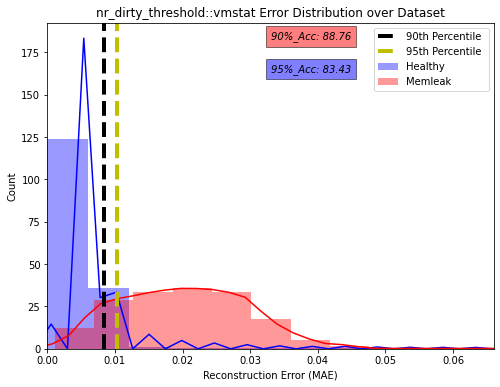

Anom data stats count    14628.000000
mean         0.021840
std          0.016988
min          0.001045
25%          0.012983
50%          0.020335
75%          0.027513
90%          0.033021
95%          0.037150
max          0.292175
Name: 77, dtype: float64


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:54: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


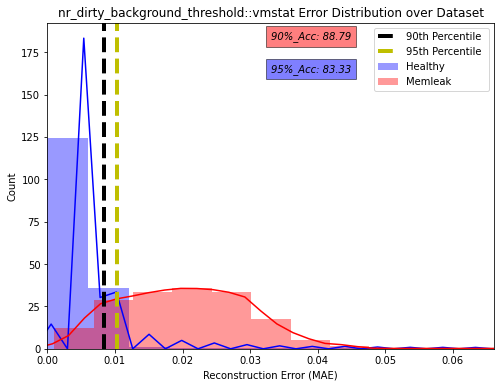

Anom data stats count    14628.000000
mean         0.000147
std          0.000365
min          0.000098
25%          0.000103
50%          0.000104
75%          0.000107
90%          0.000109
95%          0.000119
max          0.004060
Name: 84, dtype: float64


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:54: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


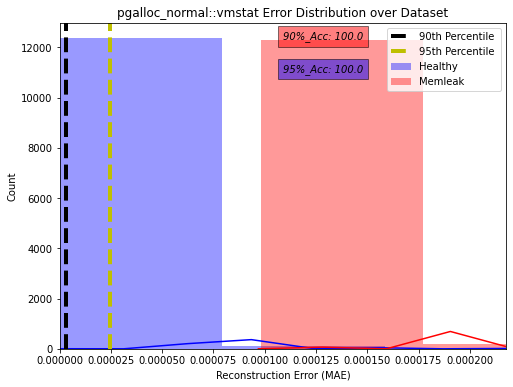

Anom data stats count    14628.000000
mean         0.000146
std          0.000366
min          0.000081
25%          0.000105
50%          0.000105
75%          0.000105
90%          0.000110
95%          0.000110
max          0.004068
Name: 135, dtype: float64


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:54: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


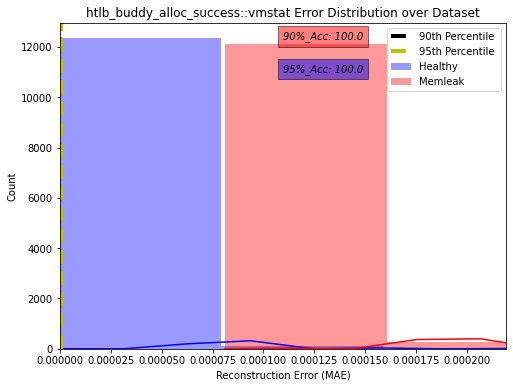

Anom data stats count    14628.000000
mean         0.021865
std          0.016987
min          0.001059
25%          0.013012
50%          0.020343
75%          0.027526
90%          0.033014
95%          0.037148
max          0.292190
Name: 170, dtype: float64


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:54: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


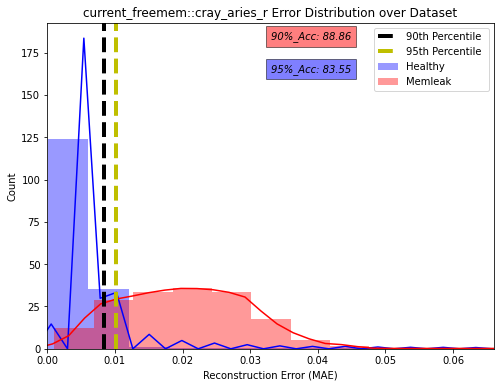

In [0]:
count_dict_y2 = plot_feature_analysis(sub_train_y2,sub_train_predict_y2,train_data_y2,predicted_memleak,"Memleak")

In [0]:
count_dict_y2

{'70': ['MemFree::meminfo',
  'MemAvailable::meminfo',
  'Active(file)::meminfo',
  'KernelStack::meminfo',
  'CommitLimit::meminfo',
  'HugePages_Total::meminfo',
  'HugePages_Surp::meminfo',
  'nr_free_pages::vmstat',
  'nr_active_file::vmstat',
  'nr_kernel_stack::vmstat',
  'nr_dirty_threshold::vmstat',
  'nr_dirty_background_threshold::vmstat',
  'pgalloc_dma32::vmstat',
  'pgalloc_normal::vmstat',
  'htlb_buddy_alloc_success::vmstat',
  'loadavg_total_processes::cray_aries_r',
  'current_freemem::cray_aries_r'],
 '85': ['MemFree::meminfo',
  'MemAvailable::meminfo',
  'Active(file)::meminfo',
  'CommitLimit::meminfo',
  'HugePages_Total::meminfo',
  'HugePages_Surp::meminfo',
  'nr_free_pages::vmstat',
  'nr_active_file::vmstat',
  'nr_dirty_threshold::vmstat',
  'nr_dirty_background_threshold::vmstat',
  'pgalloc_normal::vmstat',
  'htlb_buddy_alloc_success::vmstat',
  'current_freemem::cray_aries_r']}

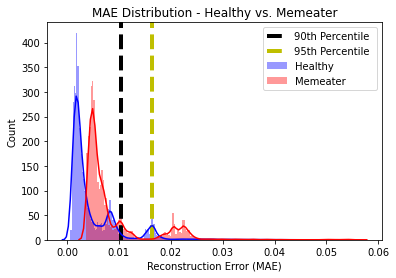

In [0]:
plot_overall_analysis(sub_train_y3,sub_train_predict_y3,train_data_y3,predicted_memeater,"Memeater")

Anom data stats count    15511.000000
mean         0.027032
std          0.020659
min          0.002576
25%          0.021795
50%          0.025015
75%          0.028542
90%          0.029679
95%          0.030352
max          0.350850
Name: 0, dtype: float64


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:54: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


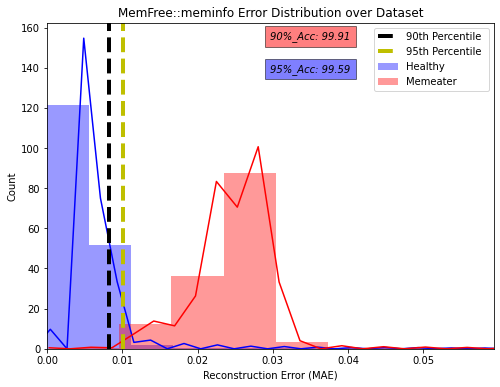

Anom data stats count    15511.000000
mean         0.027041
std          0.020669
min          0.003258
25%          0.021783
50%          0.025040
75%          0.028526
90%          0.029692
95%          0.030377
max          0.351073
Name: 1, dtype: float64


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:54: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


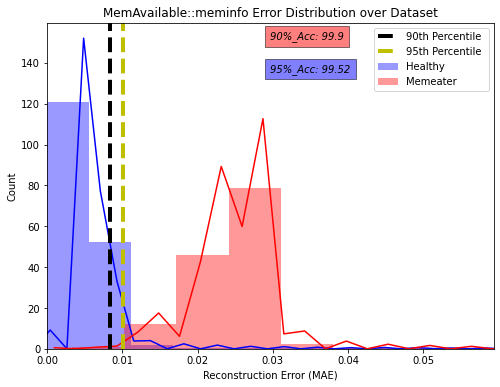

Anom data stats count    15511.000000
mean         0.039573
std          0.020453
min          0.001677
25%          0.030864
50%          0.034302
75%          0.039607
90%          0.054529
95%          0.094781
max          0.218809
Name: 9, dtype: float64


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:54: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


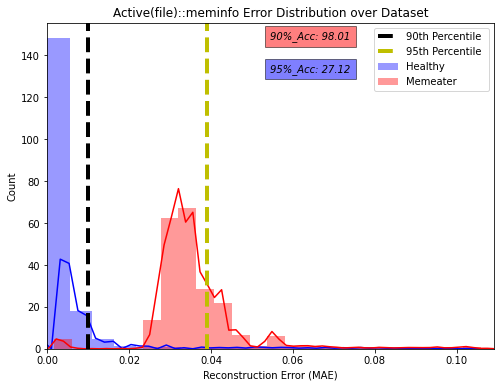

Anom data stats count    15511.000000
mean         0.025898
std          0.020774
min          0.000514
25%          0.021913
50%          0.023886
75%          0.024888
90%          0.025779
95%          0.026320
max          0.358201
Name: 28, dtype: float64


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:54: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


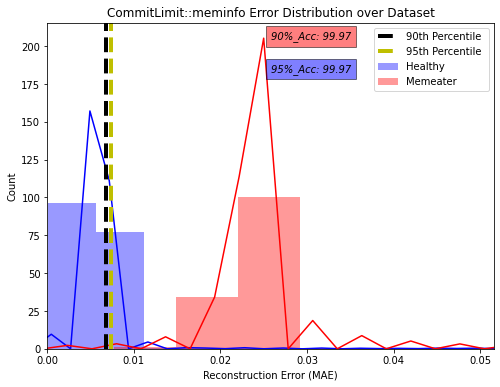

Anom data stats count    15511.000000
mean         0.024478
std          0.021099
min          0.001929
25%          0.020408
50%          0.021236
75%          0.022388
90%          0.026596
95%          0.027249
max          0.355417
Name: 33, dtype: float64


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:54: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


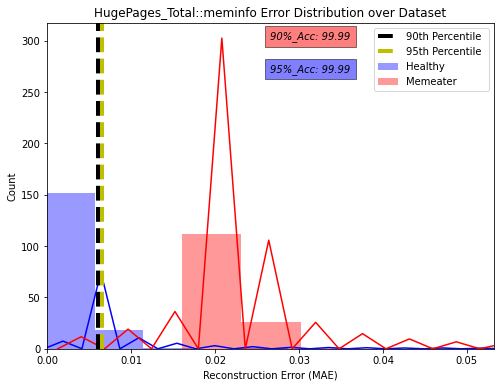

Anom data stats count    15511.000000
mean         0.016017
std          0.022287
min          0.007797
25%          0.014018
50%          0.014198
75%          0.014372
90%          0.014838
95%          0.016004
max          0.392961
Name: 34, dtype: float64


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:54: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


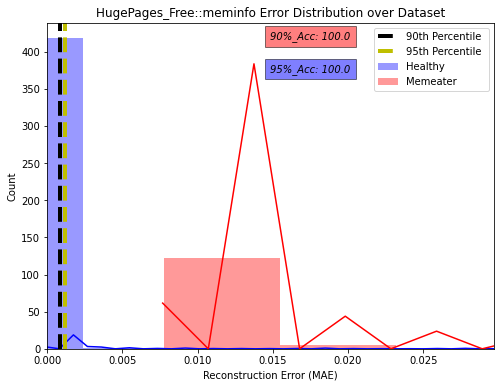

Anom data stats count    15511.000000
mean         0.016026
std          0.022757
min          0.006270
25%          0.014156
50%          0.014216
75%          0.014425
90%          0.014865
95%          0.015372
max          0.400997
Name: 35, dtype: float64


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:54: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


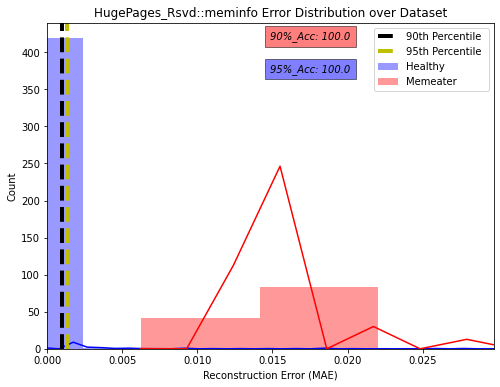

Anom data stats count    15511.000000
mean         0.024597
std          0.021052
min          0.000813
25%          0.020751
50%          0.021431
75%          0.022046
90%          0.026515
95%          0.027169
max          0.354764
Name: 36, dtype: float64


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:54: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


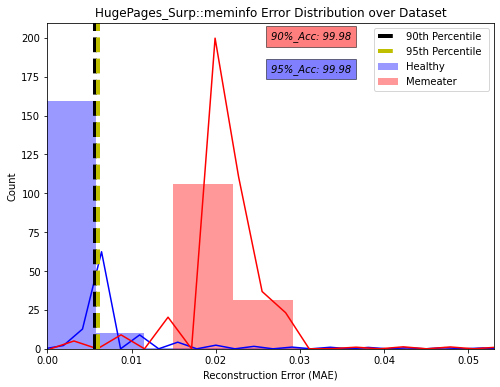

Anom data stats count    15511.000000
mean         0.027050
std          0.020675
min          0.003771
25%          0.021832
50%          0.025001
75%          0.028553
90%          0.029701
95%          0.030380
max          0.351153
Name: 37, dtype: float64


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:54: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


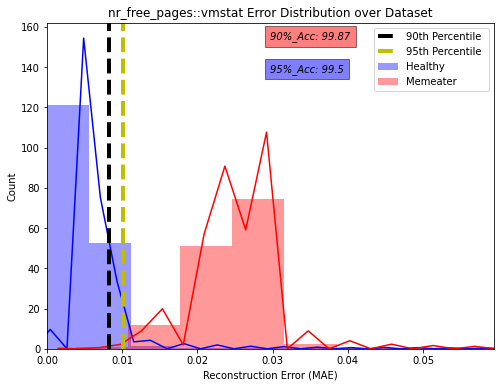

Anom data stats count    15511.000000
mean         0.039797
std          0.020519
min          0.002420
25%          0.030831
50%          0.034388
75%          0.039633
90%          0.054903
95%          0.094876
max          0.220573
Name: 42, dtype: float64


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:54: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


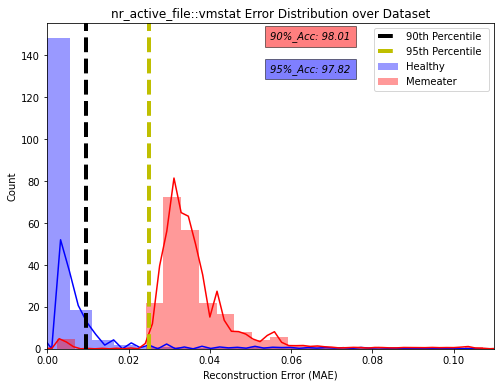

Anom data stats count    15511.000000
mean         0.027033
std          0.020687
min          0.003733
25%          0.021787
50%          0.025047
75%          0.028510
90%          0.029688
95%          0.030432
max          0.351211
Name: 76, dtype: float64


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:54: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


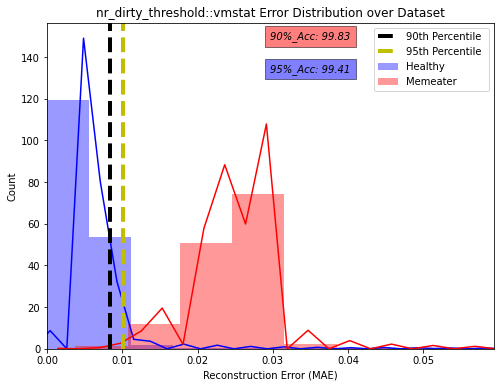

Anom data stats count    15511.000000
mean         0.027054
std          0.020680
min          0.003280
25%          0.021779
50%          0.025057
75%          0.028518
90%          0.029687
95%          0.030442
max          0.351075
Name: 77, dtype: float64


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:54: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


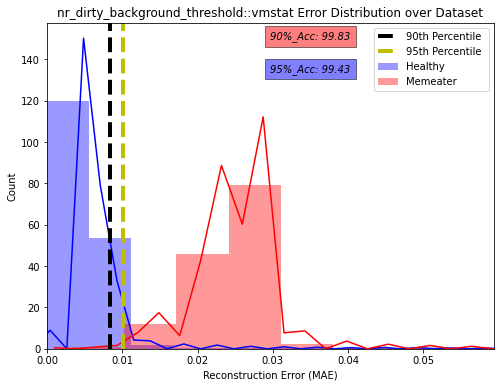

Anom data stats count    15511.000000
mean         0.027069
std          0.020685
min          0.002208
25%          0.021788
50%          0.025100
75%          0.028544
90%          0.029701
95%          0.030415
max          0.351120
Name: 170, dtype: float64


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:54: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


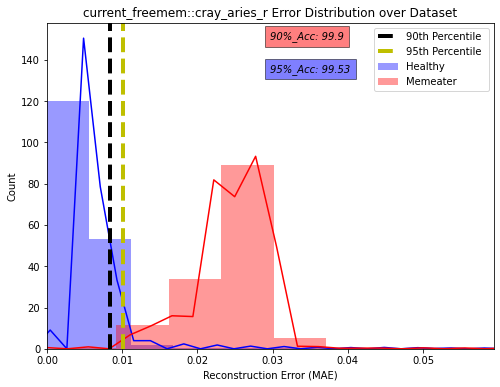

In [0]:
count_dict_y3 = plot_feature_analysis(sub_train_y3,sub_train_predict_y3,train_data_y3,predicted_memeater,"Memeater")

In [0]:
count_dict_y3

{'70': ['MemFree::meminfo',
  'MemAvailable::meminfo',
  'Active(file)::meminfo',
  'CommitLimit::meminfo',
  'HugePages_Total::meminfo',
  'HugePages_Free::meminfo',
  'HugePages_Rsvd::meminfo',
  'HugePages_Surp::meminfo',
  'nr_free_pages::vmstat',
  'nr_active_file::vmstat',
  'nr_dirty_threshold::vmstat',
  'nr_dirty_background_threshold::vmstat',
  'current_freemem::cray_aries_r'],
 '85': ['MemFree::meminfo',
  'MemAvailable::meminfo',
  'Active(file)::meminfo',
  'CommitLimit::meminfo',
  'HugePages_Total::meminfo',
  'HugePages_Free::meminfo',
  'HugePages_Rsvd::meminfo',
  'HugePages_Surp::meminfo',
  'nr_free_pages::vmstat',
  'nr_active_file::vmstat',
  'nr_dirty_threshold::vmstat',
  'nr_dirty_background_threshold::vmstat',
  'current_freemem::cray_aries_r']}

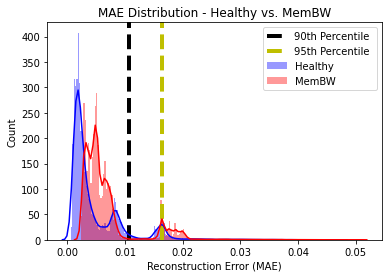

In [0]:
plot_overall_analysis(sub_train_y4,sub_train_predict_y4,train_data_y4,predicted_membw,"MemBW")

Anom data stats count    19639.000000
mean         0.042285
std          0.027011
min          0.006554
25%          0.032100
50%          0.034427
75%          0.038810
90%          0.094295
95%          0.120758
max          0.246717
Name: 9, dtype: float64


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:54: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


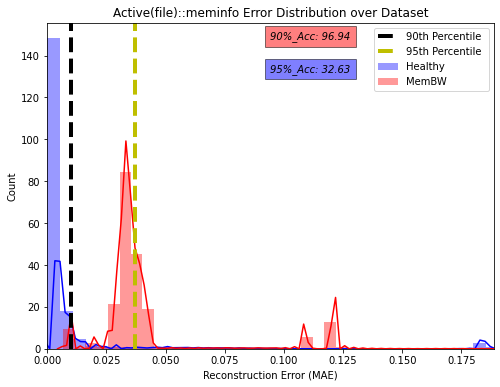

Anom data stats count    19639.000000
mean         0.041930
std          0.026190
min          0.006006
25%          0.032250
50%          0.034588
75%          0.038895
90%          0.092853
95%          0.121235
max          0.248994
Name: 42, dtype: float64


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:54: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


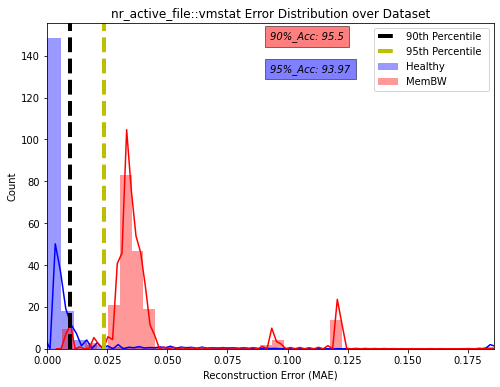

Anom data stats count    19639.000000
mean         0.014174
std          0.014546
min          0.001892
25%          0.010978
50%          0.012181
75%          0.013292
90%          0.014355
95%          0.015441
max          0.203741
Name: 157, dtype: float64


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:54: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


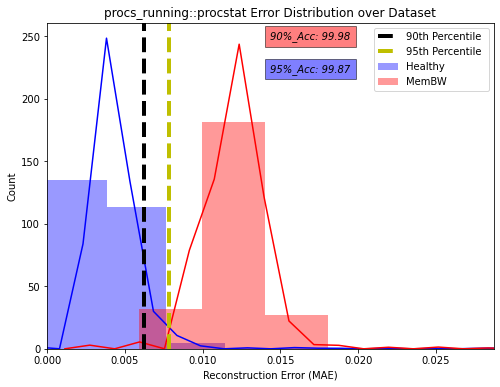

Anom data stats count    19639.000000
mean         0.012866
std          0.014674
min          0.004598
25%          0.009686
50%          0.010390
75%          0.011525
90%          0.013005
95%          0.014650
max          0.203938
Name: 168, dtype: float64


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:54: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


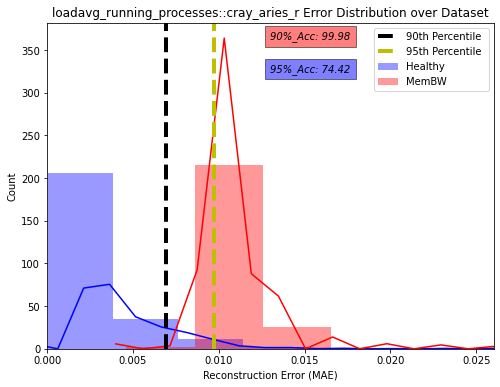

In [0]:
count_dict_y4 = plot_feature_analysis(sub_train_y4,sub_train_predict_y4,train_data_y4,predicted_membw,"MemBW")

In [0]:
count_dict_y4

{'70': ['Active::meminfo',
  'Active(file)::meminfo',
  'nr_active_file::vmstat',
  'procs_running::procstat',
  'loadavg_running_processes::cray_aries_r'],
 '85': ['Active(file)::meminfo',
  'nr_active_file::vmstat',
  'procs_running::procstat',
  'loadavg_running_processes::cray_aries_r']}

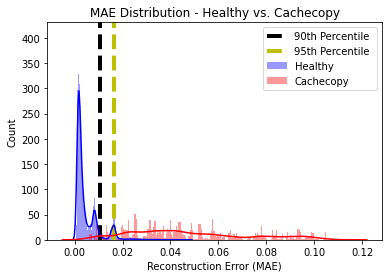

In [0]:
plot_overall_analysis(sub_train_y6,sub_train_predict_y6,train_data_y6,predicted_cachecopy,"Cachecopy")

Anom data stats count    17887.000000
mean         0.091277
std          0.063082
min          0.000503
25%          0.035816
50%          0.080399
75%          0.131376
90%          0.183977
95%          0.217236
max          0.337937
Name: 3, dtype: float64


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:54: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


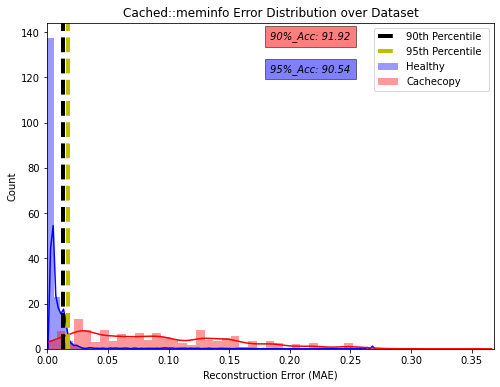

Anom data stats count    17887.000000
mean         0.116168
std          0.086481
min          0.000540
25%          0.038067
50%          0.101490
75%          0.184207
90%          0.245895
95%          0.259964
max          0.394629
Name: 5, dtype: float64


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:54: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


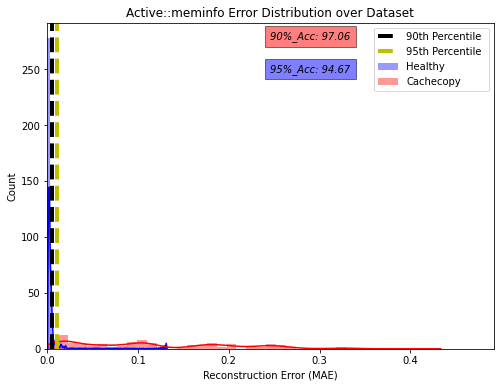

Anom data stats count    17887.000000
mean         0.091578
std          0.061987
min          0.000495
25%          0.038480
50%          0.079918
75%          0.135603
90%          0.182580
95%          0.204231
max          0.344948
Name: 6, dtype: float64


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:54: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


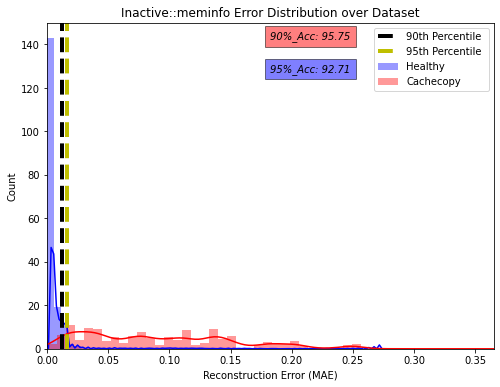

Anom data stats count    17887.000000
mean         0.120546
std          0.089826
min          0.000036
25%          0.036377
50%          0.108048
75%          0.194818
90%          0.250381
95%          0.273868
max          0.406288
Name: 7, dtype: float64


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:54: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


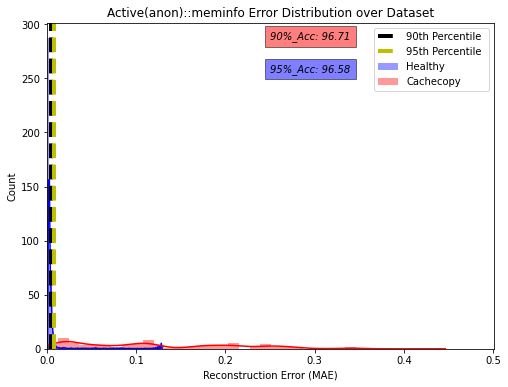

Anom data stats count    17887.000000
mean         0.048612
std          0.038371
min          0.000600
25%          0.026204
50%          0.034931
75%          0.055653
90%          0.118239
95%          0.128458
max          0.230164
Name: 9, dtype: float64


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:54: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


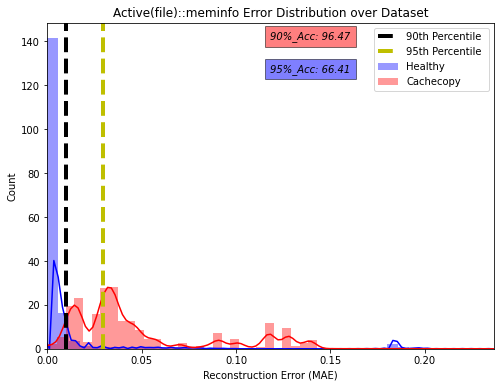

Anom data stats count    17887.000000
mean         0.123335
std          0.092327
min          0.000194
25%          0.036273
50%          0.109472
75%          0.199673
90%          0.255930
95%          0.279566
max          0.418267
Name: 17, dtype: float64


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:54: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


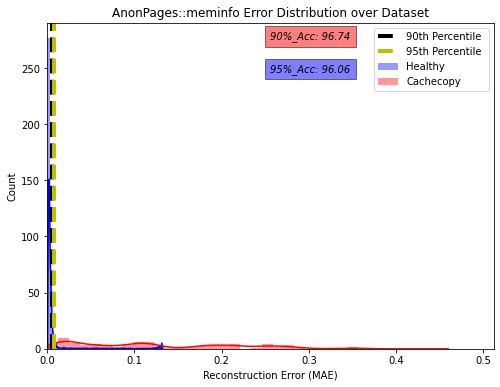

Anom data stats count    17887.000000
mean         0.106582
std          0.102696
min          0.000409
25%          0.038189
50%          0.084974
75%          0.123064
90%          0.273269
95%          0.362190
max          0.487074
Name: 21, dtype: float64


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:54: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


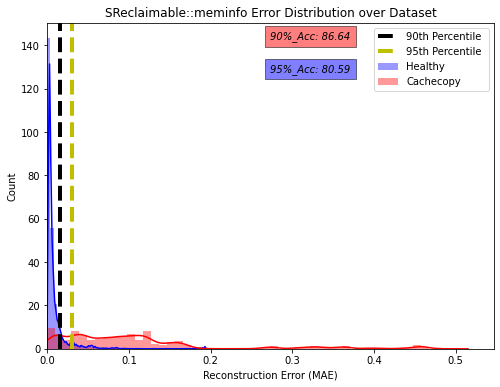

Anom data stats count    17887.000000
mean         0.312996
std          0.364928
min          0.000186
25%          0.009304
50%          0.050673
75%          0.537720
90%          0.936634
95%          0.945247
max          0.951056
Name: 28, dtype: float64


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:54: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


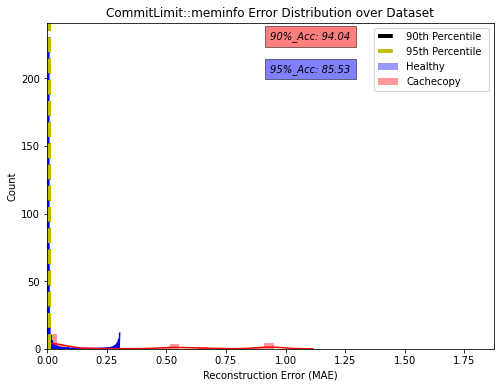

Anom data stats count    17887.000000
mean         0.120548
std          0.089836
min          0.000037
25%          0.036413
50%          0.107995
75%          0.194651
90%          0.250555
95%          0.273878
max          0.406396
Name: 40, dtype: float64


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:54: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


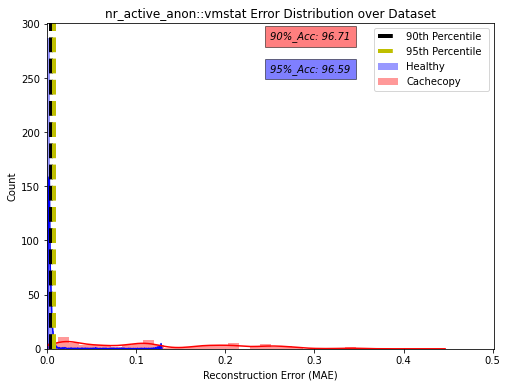

Anom data stats count    17887.000000
mean         0.048346
std          0.038629
min          0.000480
25%          0.026096
50%          0.034776
75%          0.055572
90%          0.118138
95%          0.128711
max          0.230486
Name: 42, dtype: float64


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:54: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


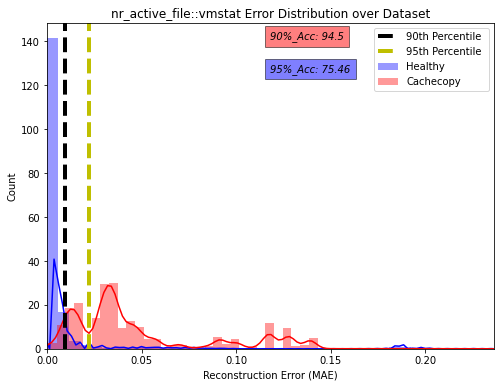

Anom data stats count    17887.000000
mean         0.123344
std          0.092335
min          0.000112
25%          0.036305
50%          0.109551
75%          0.199585
90%          0.255907
95%          0.279543
max          0.418193
Name: 45, dtype: float64


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:54: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


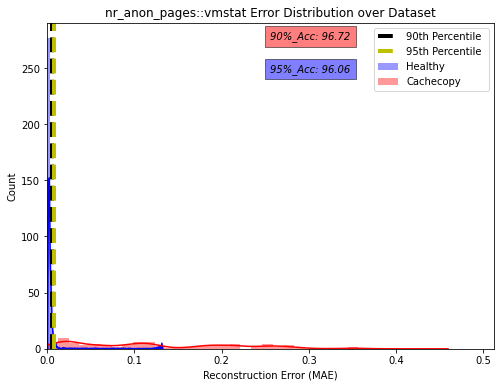

Anom data stats count    17887.000000
mean         0.087090
std          0.060044
min          0.000323
25%          0.035767
50%          0.076665
75%          0.124465
90%          0.175617
95%          0.207627
max          0.326967
Name: 47, dtype: float64


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:54: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


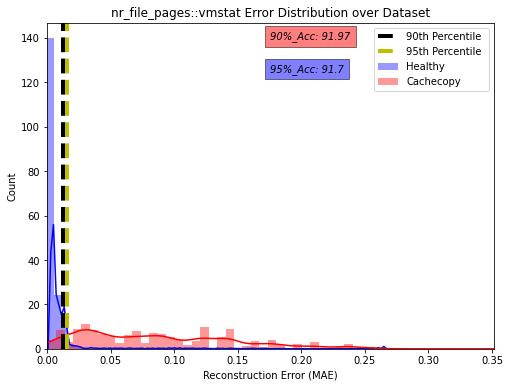

Anom data stats count    17887.000000
mean         0.106580
std          0.102708
min          0.000365
25%          0.038177
50%          0.084959
75%          0.123077
90%          0.273314
95%          0.362311
max          0.486836
Name: 50, dtype: float64


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:54: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


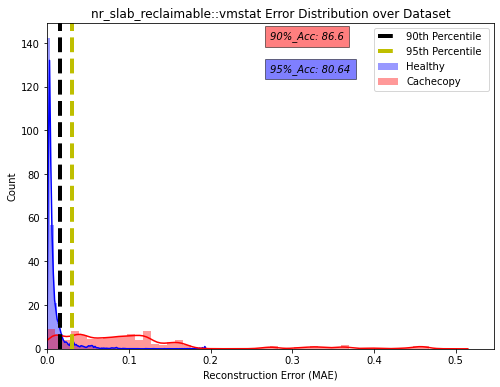

Anom data stats count    17887.000000
mean         0.013678
std          0.014866
min          0.001422
25%          0.009898
50%          0.011777
75%          0.013240
90%          0.014564
95%          0.015608
max          0.165783
Name: 157, dtype: float64


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:54: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


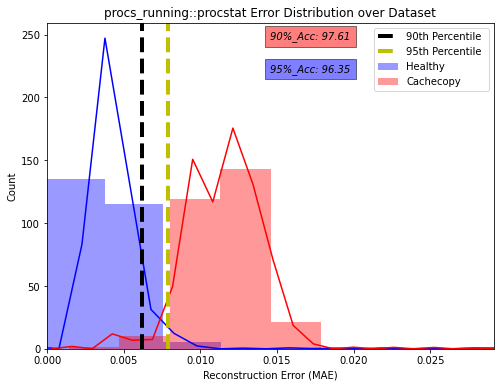

Anom data stats count    17887.000000
mean         0.012592
std          0.014914
min          0.004598
25%          0.009514
50%          0.010188
75%          0.011096
90%          0.012406
95%          0.013722
max          0.168918
Name: 168, dtype: float64


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:54: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


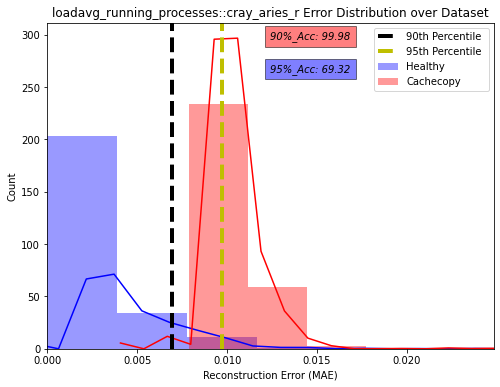

In [0]:
count_dict_y6 = plot_feature_analysis(sub_train_y6,sub_train_predict_y6,train_data_y6,predicted_cachecopy,"Cachecopy")

In [0]:
count_dict_y6

{'70': ['MemFree::meminfo',
  'MemAvailable::meminfo',
  'Cached::meminfo',
  'Active::meminfo',
  'Inactive::meminfo',
  'Active(anon)::meminfo',
  'Inactive(anon)::meminfo',
  'Active(file)::meminfo',
  'Inactive(file)::meminfo',
  'AnonPages::meminfo',
  'Mapped::meminfo',
  'Shmem::meminfo',
  'Slab::meminfo',
  'SReclaimable::meminfo',
  'SUnreclaim::meminfo',
  'KernelStack::meminfo',
  'PageTables::meminfo',
  'CommitLimit::meminfo',
  'HugePages_Total::meminfo',
  'HugePages_Surp::meminfo',
  'nr_free_pages::vmstat',
  'nr_inactive_anon::vmstat',
  'nr_active_anon::vmstat',
  'nr_inactive_file::vmstat',
  'nr_active_file::vmstat',
  'nr_anon_pages::vmstat',
  'nr_mapped::vmstat',
  'nr_file_pages::vmstat',
  'nr_slab_reclaimable::vmstat',
  'nr_slab_unreclaimable::vmstat',
  'nr_page_table_pages::vmstat',
  'nr_kernel_stack::vmstat',
  'nr_shmem::vmstat',
  'nr_dirtied::vmstat',
  'nr_written::vmstat',
  'nr_dirty_threshold::vmstat',
  'nr_dirty_background_threshold::vmstat',
 

In [0]:
print("Cpuoccupy number of features that exceed threshold1 %d and threshold2  %d" % (len(count_dict_y1["70"]),len(count_dict_y1["85"])))
print("Memleak number of features that exceed threshold1 %d and threshold2  %d" % (len(count_dict_y2["70"]),len(count_dict_y2["85"])))
print("Memeater number of features that exceed threshold1 %d and threshold2  %d" % (len(count_dict_y3["70"]),len(count_dict_y3["85"])))
print("MemBW number of features that exceed threshold1 %d and threshold2  %d" % (len(count_dict_y4["70"]),len(count_dict_y4["85"])))
print("Cachecopy number of features that exceed threshold1 %d and threshold2  %d" % (len(count_dict_y6["70"]),len(count_dict_y6["85"])))

Cpuoccupy number of features that exceed threshold1 5 and threshold2  4
Memleak number of features that exceed threshold1 17 and threshold2  13
Memeater number of features that exceed threshold1 13 and threshold2  13
MemBW number of features that exceed threshold1 5 and threshold2  4
Cachecopy number of features that exceed threshold1 41 and threshold2  15


### Classification


In [0]:
# #Train data prediction and AREM creation
# predicted_train = model.predict(mix_train_data)
# AREM_train = analyze_feature_errors(mix_train_data,predicted_train)
# print(AREM_train.shape)

# # Save data as h5py - TRAIN
# hf = h5py.File(output_directory + folder_name + '/AREM_train.h5', 'w')
# hf.create_dataset('AREM_train', data=AREM_train)
# hf.close()

# # del mix_train_data
# # del predicted_train

(83892, 199)


In [0]:
#Load h5py - TRAIN
hf_read = h5py.File(output_directory + folder_name + '/AREM_train.h5', 'r')
AREM_train = np.array(hf_read.get('AREM_train'))
unique_elements, counts_elements = np.unique(mix_train_label, return_counts=True)
print("Frequency of unique values of TRAIN LABEL")
print(np.asarray((unique_elements, counts_elements)))

Frequency of unique values of TRAIN LABEL
[[    0     1     2     3     4     5]
 [10713  8399  8718 11073 34308 10681]]


In [0]:
# #Test data prediction and AREM creation
# predicted_test = model.predict(mix_test_data)
# AREM_test = analyze_feature_errors(mix_test_data,predicted_test)
# print(AREM_test.shape)

# # Save data as h5py - TEST
# hf = h5py.File(output_directory + folder_name + '/AREM_test.h5', 'w')
# hf.create_dataset('AREM_test', data=AREM_test)
# hf.close()

In [0]:
#Load h5py - TEST
hf_read = h5py.File(output_directory + folder_name + '/AREM_test.h5', 'r')
AREM_test = np.array(hf_read.get('AREM_test'))
####
unique_elements, counts_elements = np.unique(mix_test_label, return_counts=True)
print("Frequency of unique values of TEST LABEL")
print(np.asarray((unique_elements, counts_elements)))

Frequency of unique values of TEST LABEL
[[   0    1    2    3    4    5]
 [1519 1230 1217 1989 4791 1318]]


####Train supervised clf with AREM
#####TODO:
    1-) AREM_test has low accuracy

    
#####Models:
    1-) RF - Not the best :)
    2-) xgboost
    3-) NN
    4-) RF





##### Utils

In [0]:
def prediction_wrapper(model,test_data,test_label,title=None,plot_name=None):
    preds = model.predict(X_test)
    class_names = ['cpuoccupy','memleak','memeater','membw','healthy','cachecopy']
    print(classification_report(test_label, preds, target_names=class_names))
    disp = plot_confusion_matrix(model, test_data, test_label,
                                display_labels=class_names,
                                cmap=plt.cm.Oranges,
                                normalize='true')
    if title is None:
        disp.ax_.set_title("Test - Normalized Confusion Matrix")
    else:
        disp.ax_.set_title(title)
    
    if plot_name is not None:
        plt.savefig(output_directory+folder_name+"/"+plot_name)

##### Model Training



In [0]:
#imports
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix

In [0]:
mix_train_data.shape

(83892, 45, 199)

In [0]:
#Dataset prep for training
X_train, X_test, y_train, y_test = train_test_split(AREM_train, mix_train_label, test_size=0.95, random_state=42)
#X_train, X_train_test, y_train, y_train_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

#Make a check for the label distribution of splitted datasets
unique_elements, counts_elements = np.unique(y_train, return_counts=True)
print("Frequency of unique values of " + 'y_train_label')
print(np.asarray((unique_elements, counts_elements)))

Frequency of unique values of y_train_label
[[   0    1    2    3    4    5]
 [ 529  414  425  549 1744  533]]


###### Random Forest - TPDS


In [0]:
!pip install "/content/drive/My Drive/PhD/Colab Notebooks/Explainability_Colab/fast_features-0.1.0-cp36-cp36m-linux_x86_64.whl"

In [0]:
import multiprocessing

In [0]:
_TIMESERIES = None
from fast_features import generate_features

def _get_features(node_id, features=None, **kwargs):
    global _TIMESERIES
    assert (
        features == ['max', 'min', 'mean', 'std', 'skew', 'kurt',
                     'perc05', 'perc25', 'perc50', 'perc75', 'perc95']
    )

    if isinstance(_TIMESERIES, pd.DataFrame):
        df = pd.DataFrame(
            generate_features(
                np.asarray(_TIMESERIES.loc[node_id, :, :].values.astype('float'), order='C')
            ).reshape((1, len(_TIMESERIES.columns) * 11)),
            index=[node_id],
            columns=[feature + '_' + metric
                     for metric in _TIMESERIES.columns
                     for feature in features])
        return df
    else:
        # numpy array format compatible with Burak's notebooks
        return generate_features(
                np.asarray(_TIMESERIES[node_id].astype(float), order='C')
            ).reshape((1, _TIMESERIES.shape[2] * 11))

class _FeatureExtractor:
    def __init__(self, features=None, window_size=None, trim=None):
        self.features = features
        self.window_size = window_size
        self.trim = trim

    def __call__(self, node_id):
        return _get_features(
            node_id, features=self.features,
            window_size=self.window_size, trim=self.trim)

class TSFeatureGenerator:
    """Wrapper class for time series feature generation"""

    def __init__(self, trim=60, threads=multiprocessing.cpu_count(),
                 features=['max', 'min', 'mean', 'std', 'skew', 'kurt',
                           'perc05', 'perc25', 'perc50', 'perc75', 'perc95']):
        self.features = features
        self.trim = trim
        self.threads = threads

    def fit(self, x, y=None):
        """Extracts features
            x = training data represented as a Pandas DataFrame
            y = training labels (not used in this class)
        """
        return self

    def transform(self, x, y=None):
        """Extracts features
            x = testing data/data to compare with training data
            y = training labels (not used in this class)
        """
        global _TIMESERIES
        _TIMESERIES = x
        pool = multiprocessing.Pool(self.threads)
        if isinstance(x, pd.DataFrame):
            result = pool.map(
                _FeatureExtractor(features=self.features,
                                  window_size=0, trim=self.trim),
                x.index.get_level_values('node_id').unique())
            pool.close()
            pool.join()
            return pd.concat(result)
        else:
            # numpy array format compatible with Burak's notebooks
            result = pool.map(
                _FeatureExtractor(features=self.features,
                                  window_size=0, trim=self.trim),
                range(len(x)))
            pool.close()
            pool.join()
            return np.concatenate(result, axis=0)

In [0]:
pipeline = Pipeline([
    #('assert1', CheckFeatures()),
    ('feature', TSFeatureGenerator(threads=2, trim=0)),
    #('assert2', CheckFeatures()),
    #('scaler', MinMaxScaler(feature_range=(0, 1))),
    ('clf', RandomForestClassifier(n_estimators=100, class_weight='balanced'))
    #('clf', MLPClassifier(alpha=0.05, solver='adam'))
])

In [0]:
rf_X_train, rf_X_test, rf_y_train, rf_y_test = train_test_split(mix_train_data, mix_train_label, test_size=0.95, random_state=42)

In [0]:
print(rf_X_train.shape)

(4194, 45, 199)


In [0]:
#Make a check for the label distribution of splitted datasets
unique_elements, counts_elements = np.unique(rf_y_train, return_counts=True)
print("Frequency of unique values of " + 'RF y_train')
print(np.asarray((unique_elements, counts_elements)))

Frequency of unique values of RF y_train
[[   0    1    2    3    4    5]
 [ 529  414  425  549 1744  533]]


In [0]:
!cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 63
model name	: Intel(R) Xeon(R) CPU @ 2.30GHz
stepping	: 0
microcode	: 0x1
cpu MHz		: 2300.000
cache size	: 46080 KB
physical id	: 0
siblings	: 4
core id		: 0
cpu cores	: 2
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 avx2 smep bmi2 erms invpcid xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs itlb_multihit
bogomips	: 4600.00
clflush size	: 64
cache_alignment	: 64
address sizes	: 46 bits physical, 48 bits virtual
power management

In [0]:
pipeline.fit(rf_X_train, rf_y_train)  

In [0]:
print("adasdsad")

adasdsad


###### Random Forest






In [0]:
rf_model = RandomForestClassifier(n_estimators=100, 
                                    )

In [0]:
rf_model.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [0]:
prediction_wrapper(rf_model,X_test,y_test)

In [0]:
with open(output_directory + folder_name + "/rf_model", 'wb') as f:
    pickle.dump(rf_model,f)

###### MLP

In [0]:
pipeline = Pipeline([
    # ('assert1', CheckFeatures()),
    # ('feature', TSFeatureGenerator(threads=16, trim=0)),
    # ('assert2', CheckFeatures()),
    #('scaler', MinMaxScaler(feature_range=(0, 1))),
    #('clf', RandomForestClassifier(n_estimators=100, class_weight='balanced'))
    ('clf', MLPClassifier(alpha=0.05, solver='adam'))
])

##### Model Testing

In [0]:
# #Replace the current index with nid_array in Training data
# nid_array = []
# unique_nodeids = train_data_full.index.get_level_values('node_id').unique()
# new_train_df = pd.DataFrame()

# for temp_nodeid in unique_nodeids:
#     new_id = (nodeid_df[nodeid_df.node_id == temp_nodeid].nid).array[0]
#     temp_df = train_data_full.loc[temp_nodeid]
#     #print(temp_nodeid,new_id)
#     temp_df['nid'] = new_id
#     temp_df = temp_df.reset_index()
#     temp_df =temp_df.set_index(['nid','timestamp'])
#     new_train_df = new_train_df.append(temp_df)

# #temp_df


# #Replace the current index with nid_array for labels
# nid_array_label = []
# unique_nodeids_label = train_labels_full.index.unique()

# for temp_nodeid in unique_nodeids_label:
#     new_id = (nodeid_df[nodeid_df.node_id == temp_nodeid].nid).array
#     nid_array_label.append(new_id)

# train_labels_full = pd.DataFrame(data=train_labels_full[0].values,index=nid_array_label)    